# Proyecto 2: Análisis
### Sebastián Murillo García 191838
7 de diciembre, 2021

---

In [135]:
import pandas as pd

### Notas previas
---

Antes de comenzar con el desarrollo de la solución correspondiente al `Proyecto 2`, es necesario mencionar algunas notas previas importantes. 

* En la solución al `Proyecto 1`, existieron problemas al intentar hacer la carga de datos a la base de datos en `postgres`, por lo que esa sección del proyecto quedó sin solucionar. Ya que en el proyecto que presentamos a continuación es necesaria la conexión a la base de datos para poder hacer la lectura de las tablas `raw.estaciones` y `raw.precios` a *Data Frames* de pandas, se necesitó resolver la problemática que se presentó en dicho proyecto. A continuación presentamos los cambios mínimos que se hicieron a los scripts para que la carga de datos fuera posible:

1. Las modificaciones que se hicieron al script `upload.sql` son las siguientes:

    * Se le agregaron dos instrucciones para borrar las sequencias relacionadas a las `primary_keys` de las tablas.

            drop sequence id_estacion_estaciones_seq;
            drop sequence estacion_servicio_precios_seq;
    
    * Se comentaron dos líneas:
    
            -- ALTER TABLE estaciones ALTER COLUMN id_estacion SET NOT 0;
            -- ALTER TABLE precios ALTER COLUMN estacion_servicio SET NOT 0;
        
    * Se agregó el prefijo `raw.` en la creación de las tablas `precios` y `estaciones` para que quedara como:

            create table raw.estaciones {
            ...
            };
        
            create table raw.precios {
            ...
            };

    * En la creación de la tabla `raw.estaciones`, se cambió el número de caracteres aceptables para el atributo `nombre` de 50 a 100.


2. Las modificaciones al script `proyecto_1_transform_2.sh` son las siguientes:

    * Se cambió un comando que tenía que ver con la eliminación del signo de puntuación: (.) 
        
    Solo se agregaron dos espacios.
            
            gsed -i 's/30\.3/30 3/g' estaciones.csv
            gsed -i 's/30\.3 /30 3 /g' estaciones.csv
    
    * Se agregó una línea de comando para eliminar un registro problemático de estaciones que no se copiaba a la base de datos debido a su valor. 
    
        El comando con el que se eliminó es:
    
            gsed -i '11792d' estaciones.csv
    
        El registro se encontraba en la línea 11792 y es el siguiente:

In [136]:
dato_prob = pd.DataFrame(data=[[23393,'inmobiliaria hotela sa de cv',2272.49,355773.1]],
                        columns=['id_estacion','nombre','latitud','longitud'])
dato_prob

,id_estacion,nombre,latitud,longitud
0,23393,inmobiliaria hotela sa de cv,2272.49,355773.1


* La última nota **importante** es que en la solución del `Proyecto 1`, al hacer la limpieza del archivo `estaciones.csv`, se contempló la posibilidad de eliminar los signos de puntuación problemáticos solo en la columna de nombres. Esto permitió que los datos de latitud y longitud permanecieran con sus respectivos guiones (-) y puntos (.) para denotar coordenadas negativas y con punto decimal, respectivamente. Esto es importante en la consideración de la pregunta `3.` de este proyecto, pero más adelante se hablará de ello.

Sin más por el momento, presentamos la solución al `Proyecto 2: Análisis`.

---
### Parte 1: Análisis con Pandas
---

1. Ocupamos la función `get_db_conn()` para realizar una conexión a la base de datos en postgres con `psycopg2`, leyendo del archivo `credentials.yaml`, donde se tienen las credenciales de acceso a la base de datos.

In [137]:
import yaml
import psycopg2

In [138]:
def read_yaml_file(yaml_file):
    """load yaml configurations"""
    
    config = None
    try:
        with open(yaml_file,'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load file')
    
    return config

In [139]:
def get_db_conn(cred_file):
    """Gets authorized psycopg connections from yaml file"""
    creds = read_yaml_file(cred_file)['db']
    
    connection = psycopg2.connect(
        user = creds['user'],
        password = creds["pass"],
        host = creds['host'],
        port = creds['port'],
        database = creds['db']
    )
    
    return connection

In [140]:
db_conn = get_db_conn("./conf/local/credentials.yaml")

---
2. Generamos un *query sql* para obtener (en un *data frame* llamado `data`) la información de `id_estacion`, `nombre`, `longitud`, `latitud`, `regular`, `preimum` y `diesel` de todos los precios registrados en la base de datos.

In [141]:
query = """
select e.id_estacion, e.nombre, e.longitud, e.latitud, p.regular, p.premium, p.diesel
from raw.precios p 
inner join raw.estaciones e on (e.id_estacion=p.estacion_servicio)
"""

data = pd.read_sql(query,db_conn)
#data

* ¿Cuántas observaciones se tienen?

In [142]:
num_observaciones = data.shape[0]
print("R: {} observaciones \n".format(num_observaciones))


R: 12653 observaciones 



* Número de estaciones que **no** tienen gasolina `regular`.

In [143]:
no_reg = data['regular'].isna().sum()
print("R: {} estaciones \n".format(no_reg))


R: 64 estaciones 



* Número de estaciones que **no** tienen gasolina `premium`.

In [144]:
no_prem = data['premium'].isna().sum()
print("R: {} estaciones \n".format(no_prem))


R: 901 estaciones 



* Número de estaciones que **no** tienen gasolina `diesel`.

In [145]:
no_die = data['diesel'].isna().sum()
print("R: {} estaciones \n".format(no_die))


R: 3239 estaciones 



* Número de estaciones que **solo** tienen gasolina `regular`.

In [146]:
solo_reg = data[(data['regular'].isna() == False) & data['premium'].isna() & data['diesel'].isna()]

num_solo_reg = solo_reg['id_estacion'].size
print("R: {} estaciones \n".format(num_solo_reg))


R: 123 estaciones 



* Número de estaciones que **solo** tienen gasolina `regular` **y** `premium`.

In [147]:
solo_reg_prem = data[(data['regular'].isna() == False) & (data['premium'].isna() == False) & data['diesel'].isna()]

num_reg_prem = solo_reg_prem.shape[0]
print("R: {} estaciones \n".format(num_reg_prem))


R: 3114 estaciones 



* Número de estaciones que **solo** tienen gasolina `regular` **y** `diesel`.

In [148]:
solo_reg_die = data[(data['regular'].isna() == False) & data['premium'].isna() & (data['diesel'].isna() == False)]

num_reg_die = solo_reg_die['id_estacion'].size
print("R: {} estaciones \n".format(num_reg_die))


R: 718 estaciones 



* Nombres de las estaciones que dieron gasolina `premium` "gratis".

    **Nota**: Se tomó en cuenta la posibilidad de extraer los **nombres "únicos"** de las estaciones que dieron este tipo de gasolina "gratis" con la función `unique()`. Esto se hizo ya que existen estaciones que tienen el mismo nombre y diferentes coordenadas, es decir, están establecidas en diferentes espacios. Esto no quiere decir que tengamos observaciones repetidas. 

    Si se desean obtener todos los nombres (con repetidos en diferentes coordenadas), solo se ocupa la función `values`. 

In [149]:
prem_gratis = data[data['premium'] == 0]

nombres = list(prem_gratis['nombre'].unique())
#nombres = list(prem_gratis['nombre'].values)

print("R: Estaciones que dieron gasolina premium gratis:")
for i in nombres:
    print("\t{}".format(i))


R: Estaciones que dieron gasolina premium gratis:
	comercializadora nlibja sa de cv  e09020


O bien, si requerimos tener estos datos en un *data frame* `nom_prem_gratis`.

In [150]:
nom_prem_gratis = prem_gratis[['nombre']]
nom_prem_gratis

,nombre
3652,comercializadora nlibja sa de cv e09020
3675,comercializadora nlibja sa de cv e09020
4899,comercializadora nlibja sa de cv e09020
5226,comercializadora nlibja sa de cv e09020


* Número de estaciones que venden los **tres tipos** de gasolina.

    **Nota**: Para responder esta pregunta, pudimos ocupar la función `notna()`, que es "equivalente" a utilizar la condición `isna() == False`.

In [151]:
tres_tipos = data[data['regular'].notna() & data['premium'].notna() & data['diesel'].notna()]
#tres_tipos = data[(data['regular'].isna() == False) & (data['premium'].isna() == False) & (data['diesel'].isna() == False)]

num_tres_tipos = tres_tipos.shape[0]
print("R: {} estaciones \n".format(num_tres_tipos))


R: 8634 estaciones 



---
3. En el *data frame* `data`, agregamos dos columnas: `lat` y `long`:

    * Para la columna `lat` convertimos los valores de `latitud` a una escala del **10 al 99**. Para ello, nos vamos a auxiliar de una función que creamos llamada `lat()`, la cual va a realizar la conversión.
    
        **Consideraciones de la función `lat()`**: 
        * La función convierte un valor cualquiera de más de 2 dígitos a uno **positivo** representado en el rango de las **decenas** con (o sin) punto decimal. Es decir, si tenemos el número 1085, la función lo transforma a 10.85; si tenemos el número 34, el resultado obtenido es un 34.0
        * Si el valor a convertir ya tiene un punto decimal, es decir, si ya es un valor `float`, la función respeta la posición del punto decimal. Como se comentó en el apartado *Notas previas*, en la solución del `Proyecto 1` se contempló la posibilidad de no quitar los signos de puntuación de guión y punto a las columnas `latitud` y `longitud` en el archivo `estaciones.csv`, por lo que los datos de estas columnas son fieles a los existentes en el archivo `estaciones.xml`. Esto implica que si los valores que están en la base de datos ya tienen punto decimal, dichos datos se consideran como **correctos** y no se aplica ninguna modificación. Lo único que va a hacer esta función con los datos que ya están representados con punto decimal es pasarlos a positivos, si es que son negativos. Si el dato no tiene punto decimal, se aplica la conversión a dos enteros.
        * A pesar de que se busca que los valores de `latitud` estén en una escala del 10 al 99, si el valor introducido es menor a 10 (pero mayor a 0), dicho valor se respeta. No consideramos la posibilidad de agregarle una decena o algo parecido para que pueda ser transformado dentro del rango, así como tampoco creemos que es correcto eliminarlo. Si se desea, se pueden buscar esos errores posteriormente y se podrán eliminar. De hecho, un poco más adelante ofrecemos la oportunidad de analizar cuáles son los errores para tomar una decisión al respecto.

In [152]:
# Función lat()
def lat(valor):
    res = ""
    
    # Si el valor es negativo, lo multiplica por un -1 para tener el valor en positivo.
    if(valor < 0):
        valor = valor*(-1)
    # Convierte el valor a una cadena de caracteres para después convertirlo a una lista
    # y poder manipularlo.
    cad = str(valor)
    l = list(cad)
    
    # Si el valor no tiene punto decimal y tiene más de dos dígitos, 
    # se agrega un punto entre el segundo y tercer dígito para convertirlo a decenas.
    punto = cad.find(".")
    if(punto == -1):
        if(len(l) > 2):
            l.insert(2,'.')
    
    # Se hace la "conversión" del número representado en la lista a una cadena de caracteres.
    for i in l:
        res += i
    
    # Se regresa el valor representado en caracteres a un float.
    return float(res)


Buscamos los "errores" o los datos que no cumplen con la condición para la columna `lon`.

In [153]:
# Registros que no cumplen con el rango de lat.
# Nótese que se contempla la columna 'latitud', pues es antes de la transformación.
error_lat = data[(data['latitud'] < 10) | (data['latitud'] > 99)]
error_lat

,id_estacion,nombre,longitud,latitud,regular,premium,diesel
3637,5812.0,soluciones p&ampl sapi de cv,19.41447,-99.03223,20.45,22.49,21.79
3677,5852.0,soluciones p&ampl sapi de cv,19.38820,-99.02986,20.45,22.49,NaN
4846,7024.0,soluciones p&ampl sapi de cv,19.48694,-99.03712,20.55,22.59,21.99
4968,7146.0,soluciones p&ampl sapi de cv,19.35144,-98.85688,20.19,22.59,21.49


Creamos la columna `lat` que aplica la función `lat()` a los valores de la columna `latitud` y la insertamos en nuestro *data frame* `data`.

In [154]:
lat = data['latitud'].apply(lat)
#lat

data.insert(loc=4, column="lat", value=lat)

Buscamos nuevamente los "errores" o los datos que no cumplen con la condición para la columna `lat`. Así podemos hacer un análisis de las posibilidades de por qué dicho dato no se encuentra en el rango esperado y tomar una decisión al respecto.

In [155]:
# Registros que no cumplen con el rango de lat.
# Nótese que se contempla la columna 'lat', pues es después de la transformación.
e_lat = data[(data['lat'] < 10) | (data['lat'] > 99)]
e_lat

,id_estacion,nombre,longitud,latitud,lat,regular,premium,diesel
3637,5812.0,soluciones p&ampl sapi de cv,19.41447,-99.03223,99.03223,20.45,22.49,21.79
3677,5852.0,soluciones p&ampl sapi de cv,19.38820,-99.02986,99.02986,20.45,22.49,NaN
4846,7024.0,soluciones p&ampl sapi de cv,19.48694,-99.03712,99.03712,20.55,22.59,21.99


¿Todavía tenemos datos que son erróneos? Ante una respuesta afirmativa, ¿qué podemos hacer con esos datos? ¿Por qué son erróneos?

* Para la columna `lon` convertimos los valores de `longitud` a **negativos** en una escala **entre -120 y -99**. Para ello, nos vamos a auxiliar de una función que creamos llamada `lon()`.

    **Consieraciones de la función `lon()`**:
    * La función convierte un valor cualquiera de más de 2 dígitos a uno **negativo** representado en el rango de las **decenas** con (o sin) punto decimal. Si el valor es un número que empieza con 1, se convierte a un número también **negativo** reprecentado en las **centenas**. Es decir, si tenemos el número 37582, la función lo transforma a -37.582; si tenemos el número 18740, el resultado obtenido es un -187.40 (a pesar de no encontrarse en el rango).
    * Al igual que la función `lat()`, la función `lon()` contempla a los datos que ya tienen punto decimal como **valores correctos**, a menos que sean positivos, a los cuales solo se les multiplica por un -1. Esto sigue la filosofía de que la información de dichos valores ya está correcta. Si existe un error en la representación decimal de los mismos, escapa de nuestras manos. Solo aceptamos el "error de dedo" de que se haya registrado el dato como positivo. Si el valor no tiene punto decimal, se realiza la transformación deseada.
    * A pesar de que se busca que los valores de `longitud` estén en una escala del -120 al -99, nos podemos encontrar con la posibilidad de enfrentarnos con datos que por la naturaleza del acomodo de sus dígitos no se encuentren dentro del rango después de la transformación (como el caso del número 18740 mencionado en el primer inciso). No consideramos que sea correcto modificar esos datos. Por lo tanto, ambos métodos: `lat()` y `lon()` consideran que la información del acomodo de los dígitos es correcta para poner el punto donde debe. Ya si se desea, se pueden buscar esos datos posteriormente. Del mismo modo como lo hicimos para el caso de la columna `lat`, vamos a buscar esos posibles errores.

In [156]:
# Función lon()
def lon(valor):
    res = ""
    
    # Si el valor es negativo, lo multiplica por un -1 para tener el valor en positivo.
    # De esta manera podemos buscar más fácilmente si el primer dígito es un uno (1).
    if(valor < 0):
        valor = valor*(-1)
    # Convierte el valor a una cadena de caracteres para después convertirlo a una lista 
    # y poder manipularlo.
    cad = str(valor)
    l = list(cad)
    
    # Si el valor no tiene punto decimal hacemos la transformación dependiendo del caso.
    punto = cad.find(".")
    if(punto == -1):
        if(len(l) > 2):
            # Si el valor es mayor a dos dígitos y empieza con 1, 
            # se agrega un punto entre el tercer y cuarto dígito para convertirlo a centenas.
            # En otro caso, se agrega el punto entre el segundo y tercero para convertirlo a decenas.
            if(cad.startswith("1")):
                l.insert(3,'.')
            else:
                l.insert(2,'.')

    # Se hace la "conversión" del número representado en la lista a una cadena de caracteres.
    for i in l:
        res += i
    
    # # Se regresa el valor representado en caracteres a un float negativo.
    return float(res)*(-1)

Buscamos los "errores" o los datos que no cumplen con la condición para la columna `lon`. 

**Nota**: Debemos decir que al buscar cuáles eran los errores, nos percatamos de que hay muchos valores entre -99 y -80. Al principio creimos que había sido un error en la limpieza del archivo `estaciones.csv` y que tal vez nos habíamos "comido" un dígito. Con ayuda de la línea de comando confirmamos que dichos valores sí se encuentran en el archivo `estaciones.xml`. Además, al hacer el mapa de las estaciones (ya para el final de este proyecto) también observamos que esos datos sí pueden encontrarse en el rango, pues se encuentran dentro del territorio mexicano, alrededor (o cerca) de la península de Yucatán. Debido a ello, decidimos ampliar el invervalo de valores posibles a números entre -120 y -80.

In [157]:
# Registros que no cumplen con la condición de lon.
# Nótese que se contempla la columna 'longitud', dado que es antes de la transformación.
error_lon = data[(data['longitud'] < -120) | (data['longitud'] > -80)]
error_lon

,id_estacion,nombre,longitud,latitud,lat,regular,premium,diesel
3637,5812.0,soluciones p&ampl sapi de cv,19.41447,-99.03223,99.03223,20.45,22.49,21.79
3677,5852.0,soluciones p&ampl sapi de cv,19.38820,-99.02986,99.02986,20.45,22.49,NaN
4846,7024.0,soluciones p&ampl sapi de cv,19.48694,-99.03712,99.03712,20.55,22.59,21.99
4968,7146.0,soluciones p&ampl sapi de cv,19.35144,-98.85688,98.85688,20.19,22.59,21.49
11644,23170.0,servicios gasolineros de mexico sa de cv,101.59870,21.07213,21.07213,19.85,22.99,21.99
11645,23172.0,servicios gasolineros de mexico sa de cv,102.24090,21.28889,21.28889,20.79,22.99,21.99
11646,23173.0,servicios gasolineros de mexico sa de cv,100.92280,25.52974,25.52974,21.19,23.15,22.19
11647,23175.0,servicios gasolineros de mexico sa de cv,101.02940,25.40808,25.40808,20.99,22.99,20.16
11648,23176.0,servicios gasolineros de mexico sa de cv,100.84710,25.61313,25.61313,21.29,23.19,22.19
11649,23177.0,servicios gasolineros de mexico sa de cv,101.49000,20.98868,20.98868,20.49,22.99,21.89


Creamos la columna `lon` que aplica la función `lon()` a los valores de la columna `longitud` y la insertamos en nuestro *data frame* `data`.

In [158]:
lon = data['longitud'].apply(lon)
#lon

data.insert(loc=3, column="lon", value=lon)

Buscamos nuevamente los "errores" o los datos que no cumplen con la condición para la columna `lon`. Así podemos hacer un análisis de las posibilidades de por qué dicho dato no se encuentra en el rango esperado y tomar una decisión al respecto.

In [159]:
# Registros que no cumplen con la condición de lon.
# Nótese que se contempla la columna 'lon', dado que es después de la transformación.
e_lon = data[(data['lon'] < -120) | (data['lon'] > -80)]
e_lon

,id_estacion,nombre,longitud,lon,latitud,lat,regular,premium,diesel
3637,5812.0,soluciones p&ampl sapi de cv,19.41447,-19.41447,-99.03223,99.03223,20.45,22.49,21.79
3677,5852.0,soluciones p&ampl sapi de cv,19.38820,-19.38820,-99.02986,99.02986,20.45,22.49,NaN
4846,7024.0,soluciones p&ampl sapi de cv,19.48694,-19.48694,-99.03712,99.03712,20.55,22.59,21.99
4968,7146.0,soluciones p&ampl sapi de cv,19.35144,-19.35144,-98.85688,98.85688,20.19,22.59,21.49


¿Todavía tenemos datos que son erróneos? Ante una respuesta afirmativa, ¿qué podemos hacer con esos datos? ¿Por qué son erróneos?

* Eliminamos las columnas `latitud` y `longitud` en el mismo *data frame* `data`.

In [160]:
data.drop(['latitud','longitud'], axis=1, inplace=True)
#data

* Generamos un `describe()` al *data frame* `data` e interpretamos los resultados de los valores correspondientes a los **precios** de los **tipos de gasolina**.

In [161]:
data.describe()

,id_estacion,lon,lat,regular,premium,diesel
count,12653.000000,12653.000000,12653.000000,12589.000000,11752.000000,9414.000000
mean,10041.172765,-101.286068,22.374466,20.176089,22.205030,21.638703
std,6520.889633,5.967914,4.375568,1.337856,1.449735,1.214160
min,2039.000000,-117.120200,14.672430,11.710000,0.000000,0.000000
25%,5338.000000,-103.452900,19.394360,19.750000,21.880000,21.150000
50%,8509.000000,-100.371800,20.683730,20.290000,22.450000,21.760000
75%,12313.000000,-98.423230,25.547950,20.990000,22.990000,22.290000
max,27600.000000,-19.351440,99.037120,25.050000,26.060000,29.290000


#### Interpretación:

* **Count**: El tipo de gasolina que más se encuentra en las estaciones es la del tipo `regular` con 12,589 estaciones que la venden. La gasolina `diesel` es más "exclusiva" en cuanto el número de estaciones que la venden: 9414 gasolineras.


* **Mean**: En promedio y en todas las estaciones registradas en nuestra base de datos, la gasolina `premium` es la más cara de los tipos de gasolina con 22.20 pesos, mientras que la `regular` es la más barata con 20.17 pesos.


* **Std**: El tipo de gasolina `premium` tiene la mayor desviación estándar de entre los tres tipos, mientras que la del tipo `diesel` la menor. Esto hace referencia a que el precio de la gasolina `premium` tiene más variaciones en su valor en comparación con los otros dos tipos. ¿Esto a qué puede deberse? Podemos especular que como la gasolina `premium` es la "más limpia" en sus componentes, su precio puede variar dependiendo de la demanda del lugar en el que se venda. Por otro lado, como la gasolina `diesel` es más ocupada por autobuses, tráilers, camiones de carga, etcétera, podemos decir que su precio se encuentra más estabilizado debido a que su demanda es relativamente baja y es ocupada por aquellos transportes de servicios y bienes. Repitamos: solo son especulaciones.


* **Min**: El precio más bajo de venta del tipo de gasolina `regular` es de 11.71 pesos, mientras que el precio más barato al que se ofrecen los tipos de gasolina `premium` y `diesel` es de 0 pesos, es decir, gratis. Esto es curioso y nos brida la posibilidad de hacernos las preguntas: ¿realmente hubo estaciones que regalaron estos tipos de gasolina?, ¿o acaso fue un error de dedo? Tal vez se equivocaron los que llenaron la información y aquellas estaciones que no vendían un tipo de gasolina les pusieron que 0 pesos. Quién sabe.


* **25%**: El 25% de las estaciones de gasolina vendieron: del tipo `regular` a un precio menor (o igual) a 19.75 pesos, del tipo `premium` menor (o igual) a 21.88 pesos y del tipo `diesel` fue menor (o igual) a 21.15 pesos.


* **50%**: El 50% de las estaciones ofrecieron: gasolina `regular` a un precio menor (o igual) a 20.29 pesos, del tipo `premium` menor (o igual) a 22.45 pesos y gasolina del tipo `diesel` menor (o igual) a 21.76 pesos.


* **75%**: El 75% de las estaciones de gasolina vendieron: gasolina `regular` a un precio menor (o igual) a 20.99 pesos, gasolina `premium` con un precio menor (o igual) a 22.99 pesos, y gasolina `diesel` a menor o igual precio que 22.29 pesos. 


* **Max**: El tipo de gasolina que tiene el precio más caro en alguna de las estaciones es el de la gasolina `diesel` a 29.29 pesos, mientras que el más barato fue de 25.05 pesos para la gasolina `regular`. Estos son los precios de venta más caros para cada tipo de gasolina. 

* Nombres y coordenadas de las estaciones que tienen el precio **más caro** de gasolina `regular`.

In [162]:
max_r = data[data['regular'] == data['regular'].max()]

nombres_r = list(max_r['nombre'].values)
lat_r = list(max_r['lat'].values)
lon_r = list(max_r['lon'].values)

print("R: Estaciones que tienen el precio más caro de gasolina regular:")
print("\t Nombre: (x = lon, y = lat)")
for i in range(len(nombres_r)):
    print("\t {}: ({}, {})".format(nombres_r[i],lon_r[i],lat_r[i]))
    

R: Estaciones que tienen el precio más caro de gasolina regular:
	 Nombre: (x = lon, y = lat)
	 combustibles aja sa de cv: (-98.21723, 19.06049)
	 combustibles resurgimiento sa de cv: (-98.18135, 19.04007)
	 combustibles jv sa de cv: (-98.1857, 19.03503)


O bien, si queremos tener estos datos en un *data frame* `data_max_r`.

In [163]:
data_max_r = max_r[['nombre','lon','lat']]
data_max_r

,nombre,lon,lat
4750,combustibles aja sa de cv,-98.21723,19.06049
4804,combustibles resurgimiento sa de cv,-98.18135,19.04007
5249,combustibles jv sa de cv,-98.18570,19.03503


* Nombres y coordenadas de las estaciones que tienen el precio **más caro** de gasolina `premium`.

    **Nota**: Para responder este y los siguientes incisos solamente se mostrará el *data frame* correspondiente a los valores de nombres y coordenadas de las estaciones que cumplan con la condición deseada. Si se deseara obtener un resultado "impreso" en la consola, se puede hacer un código análogo al inciso anterior. Esto se decidió para no hacer el notebook tan largo y "repetitivo" en las formas de presentar el resultado. Además, tener los *data frames* "aislados" ofrece la posibilidad de poder jugar con ellos en análisis futuros, si es necesario.

In [164]:
data_max_p = data[data['premium'] == data['premium'].max()][['nombre','lon','lat']]
data_max_p

,nombre,lon,lat
4750,combustibles aja sa de cv,-98.21723,19.06049
4804,combustibles resurgimiento sa de cv,-98.18135,19.04007
5249,combustibles jv sa de cv,-98.18570,19.03503


**Dato curioso**: Las estaciones que venden la gasolina `regular` más cara son las mismas que las que venden más cara la gasolina `premium`.

* Nombres y coordenadas de las estaciones que tienen el precio **más caro** de gasolina `diesel`.

In [165]:
data_max_d = data[data['diesel'] == data['diesel'].max()][['nombre','lon','lat']]
data_max_d

,nombre,lon,lat
12324,surtilago gasolinerias sa de cv,-101.2121,19.7268


* Nombres y coordenadas de las estaciones que tienen el precio **más barato** de gasolina `regular`.

In [166]:
data_min_r = data[data['regular'] == data['regular'].min()][['nombre','lon','lat']]
data_min_r

,nombre,lon,lat
6101,energeticos del valle sa de cv,-98.08273,25.98355


* Nombres y coordenadas de las estaciones que tienen el precio **más barato** de gasolina `premium`.

    **Nota**: Es momento de recordar que al aplicar el `describe()` al *data frame* `data` obtuvimos que el menor precio de venta de la gasolina `premium` es igual a 0 pesos. Además, en otro inciso anterior obtuvimos el nombre de las estaciones que vendían gasolina `premium` "gratis". Por lo tanto, esto debe tener congruencia con el *data frame* que vamos a generar a continuación: `data_min_p`. 
    
    Concientemente agregamos la columna `premium` para analizar este dato. Si no se desea tener, utilizar la línea comentada, en la cual solo se considera el nombre y las coordenadas.

In [167]:
min_p = data[data['premium'] == data['premium'].min()]

data_min_p = min_p[['nombre','lon','lat','premium']]
#data_min_p = min_p[['nombre','lon','lat']]
data_min_p

,nombre,lon,lat,premium
3652,comercializadora nlibja sa de cv e09020,-97.43740,25.83686,0.0
3675,comercializadora nlibja sa de cv e09020,-97.55154,25.87252,0.0
4899,comercializadora nlibja sa de cv e09020,-97.50220,25.71633,0.0
5226,comercializadora nlibja sa de cv e09020,-97.43650,25.78265,0.0


**Pregunta obligada**: Si no consideramos aquellas estaciones que venden gasolina `premium` "gratis", ¿cuáles estaciones tienen el precio más barato de este tipo de gasolina y cuál es su precio? Para responder a ello, presentamos el siguiente *data frame*: `data_min_p_cero`

In [168]:
data_prem_cero = data[data['premium'] != 0]
min_p_cero = data_prem_cero[data_prem_cero['premium'] == data_prem_cero['premium'].min()]

data_min_p_cero = min_p_cero[['nombre','lon','lat','premium']]
data_min_p_cero

,nombre,lon,lat,premium
2826,gasolineria hogar sa de cv,-97.30480,25.50027,0.01
8015,moma combustibles sa de cv,-96.00312,18.11319,0.01
9307,grupo herco s a de c v,-93.31953,18.27590,0.01
9987,oil services tres sa de cv,-98.18694,19.33812,0.01
10519,miguel angel cuatepitzi juarez,-98.19884,19.25383,0.01
10524,miguel angel cuatepitzi juarez,-98.22906,19.21232,0.01
10597,guillermo primitivo villegas ayala,-102.01830,20.33526,0.01
10694,juvenal diaz diaz,-100.41230,22.03479,0.01


Tenemos que el segundo precio más barato de gasolina `premium` es de 0.01 pesos. ¡Sigue siendo casi "gratis"!

* Nombres y coordenadas de las estaciones que tienen el precio **más barato** de gasolina `diesel`.

    **Nota**: Al igual que el inciso pasado, recordamos que en el `describe()` se obtuvo que el precio más bajo de gasolina `diesel` registrado en nuestra base de datos es de 0 pesos. Comprobaremos esta información.
    
    Añadimos la columna `diesel` para comprobar los datos obtenidos. Si no se desea tener, utilizar la línea comentada para solamente tener los nombres y las coordenadas de las estaciones.

In [169]:
min_d = data[data['diesel'] == data['diesel'].min()]

data_min_d = min_d[['nombre','lon','lat','diesel']]
#data_min_d = min_d[['nombre','lon','lat']]
data_min_d

,nombre,lon,lat,diesel
2028,bp estaciones y servicios energeticos sa de cv,-117.0545,32.366,0.0


**Pregunta obligada**: De la misma manera, nos tomaremos la libertad de buscar aquellas estaciones que tengan el precio más barato de gasolina `diesel` si no consideramos aquellas que la dan "gratis". ¿Cuál será el segundo precio más barato de este tipo de gasolina? Generamos el *data frame* `data_min_d_cero`.

In [170]:
data_die_cero = data[data['diesel'] != 0]
min_d_cero = data_die_cero[data_die_cero['diesel'] == data_die_cero['diesel'].min()]

data_min_d_cero = min_d_cero[['nombre','lon','lat','diesel']]
data_min_d_cero

,nombre,lon,lat,diesel
9923,servicio playa del mar sa de cv,-94.46283,18.14988,0.01
10597,guillermo primitivo villegas ayala,-102.01830,20.33526,0.01


Nuevamente tenemos que el segundo precio más barato de gasolina `diesel` es de 0.01 pesos. Curioso.

---
4. CDMX

* Ya que estamos en la Ciudad de México, verificamos las latitudes y longitudes posibles de la CDMX y generamos un *data frame* que contiene aquellas estaciones que se encuentran dentro de las coordenadas extremas de la ciudad.
    
**Coordenadas extremas de la CDMX**:
    
Latitud:
- Norte: 19.36
- Sur: 19.03
    
Longitud
- Este: -98.57
- Oeste: -99.22

Referencias: 
- [Condiciones Geográficas, Población y Desarrollo Económico del Distrito Federal y la Zona Metropolitana](https://paot.org.mx/centro/inegi/ambdf/condic.html)
- [Medio físico: Disfrito Federal](http://www.inafed.gob.mx/work/enciclopedia/EMM09DF/mediofisico.html)
    
De esta manera generamos el *data frame* `cdmx`:

In [171]:
cdmx = data[(data['lat'] >= 19.03) & (data['lat'] <= 19.36)\
            & (data['lon'] >= -99.22) & (data['lon'] <= -98.57)]
#cdmx

¿A qué estación de gasolina nos convendría ir a llenar el tanque para cada tipo de gasolina sin importar la distancia? La respuesta la encontramos en aquellas estaciones que venden la gasolina lo **más barato** posible. Dependiendo de dónde nos encontremos, nos podemos hacer la pregunta: ¿la distancia vale el precio? Recordemos que en la CDMX las distancias se miden en horas (JAJAJA).

**Regular**:

In [172]:
min_r_cdmx = cdmx['regular'].min()
cdmx_regular = cdmx[cdmx['regular'] == min_r_cdmx][['nombre','lon','lat']]

print("Con un precio de ${}, la estación que vende gasolina regular más barata en la CDMX es:".format(min_r_cdmx))
cdmx_regular


Con un precio de $18.92, la estación que vende gasolina regular más barata en la CDMX es:


,nombre,lon,lat
2965,fertonio sa de cv,-98.89989,19.26227


**Premium**:

In [173]:
min_p_cdmx = cdmx['premium'].min()
cdmx_premium = cdmx[cdmx['premium'] == min_p_cdmx][['nombre','lon','lat']]

print("Con un precio de ${}, la estación que vende gasolina premium más barata en la CDMX es:".format(min_p_cdmx))
cdmx_premium


Con un precio de $18.25, la estación que vende gasolina premium más barata en la CDMX es:


,nombre,lon,lat
9956,gasolineria el aguila sa de cv,-98.88158,19.25364


**Diesel**:

In [174]:
min_d_cdmx = cdmx['diesel'].min()
cdmx_diesel = cdmx[cdmx['diesel'] == min_d_cdmx][['nombre','lon','lat']]

print("Con un precio de ${}, la estación que vende gasolina diesel más barata en la CDMX es:".format(min_d_cdmx))
cdmx_diesel


Con un precio de $18.79, la estación que vende gasolina diesel más barata en la CDMX es:


,nombre,lon,lat
5897,fuerte apache sa de cv,-98.88029,19.11482
9114,combustibles de chalco sa de cv,-98.89622,19.26069


* Conteo del número de estaciones en la CDMX que venden cada tipo de gasolina.

In [175]:
cdmx_melt = cdmx.melt(id_vars=['id_estacion','nombre','lon','lat'], value_vars=['regular','premium','diesel'],\
                     var_name="tipo_gasolina", value_name="precio")

conteo_cdmx = cdmx_melt.groupby(['tipo_gasolina'], as_index=False)['precio'].count()\
.rename(columns={'precio': 'num_estaciones'})

conteo_cdmx

,tipo_gasolina,num_estaciones
0,diesel,134
1,premium,194
2,regular,203


---
5. Generamos un nuevo *data frame* para juntar las columnas `regular`, `premium` y `diesel` en dos nuevas columnas: `tipo_gasolina` y `precio`. A este nuevo *data frame* le llamaremos `new_data` (bastante original, ¿no?).

In [176]:
new_data = data.melt(id_vars=['id_estacion','nombre','lon','lat'], value_vars=['regular','premium','diesel'],\
                     var_name="tipo_gasolina", value_name="precio")
new_data

,id_estacion,nombre,lon,lat,tipo_gasolina,precio
0,2039.0,estacion de servicio calafia sa de cv,-116.92140,32.47641,regular,20.29
1,2040.0,las mejores estaciones sa de cv,-99.74484,20.30370,regular,20.09
2,2041.0,diaz gas sa de cv,-106.45140,31.71947,regular,15.79
3,2042.0,combuexpress sa de cv,-103.30420,20.71413,regular,20.09
4,2043.0,petromax sa de cv,-98.29977,26.03787,regular,16.69
...,...,...,...,...,...,...
37954,27589.0,era tech combustibles sa de cv,-107.69810,24.75846,diesel,21.99
37955,27592.0,la piedad grupo gasolinero sapi de cv,-100.25820,20.57450,diesel,20.60
37956,27597.0,pro m3 infraestructura sa de cv,-100.45730,20.82254,diesel,NaN
37957,27599.0,servicio facil del sureste sa de cv,-94.95576,17.89041,diesel,20.59


* ¿Cuántas observaciones se tienen?

In [177]:
num_observaciones = new_data.shape[0]
print("R: {} observaciones \n".format(num_observaciones))


R: 37959 observaciones 



* Generamos un `describe()` al *data frame* `new_data` e interpretamos los resultados de los valores correspondientes al **precio**. ¿Realmente cambian mucho las estadísticas?

In [178]:
new_data.describe()

,id_estacion,lon,lat,precio
count,37959.000000,37959.000000,37959.000000,33755.000000
mean,10041.172765,-101.286068,22.374466,21.290388
std,6520.717839,5.967757,4.375453,1.611983
min,2039.000000,-117.120200,14.672430,0.000000
25%,5338.000000,-103.452900,19.394360,20.420000
50%,8509.000000,-100.371800,20.683730,21.500000
75%,12313.000000,-98.423230,25.547950,22.390000
max,27600.000000,-19.351440,99.037120,29.290000


#### Interpretación y comparación:

* **Count**: En total existen 33,755 precios de gasolina. Estos pueden ser iguales o diferentes, y en una estación de gasolina pueden encontrarse máximo hasta 3 valores precios, mínimo 1. Este dato es menor al número de estaciones de las que tenemos registro en el *data frame* `new_data`, ya que puede haber estaciones que no vendan algunos tipos de gasolina. Si sumamos el valor del `count` del `describe()` anterior, obtendremos este valor.


* **Mean**: En promedio y sin importar su tipo, el precio de la gasolina fue de 21.29 pesos. Aquí estamos haciendo el promedio de todos los precios registrados en las estaciones de nuestra base de datos y podemos observar que este promedio es mayor al promedio del precio de gasolina `regular` en el `describe()` anterior, pero menor que el de los otros dos tipos.


* **Std**: Por sí solo, este dato podemos interpretarlo como que el precio de la gasolina en general varía aproximadamente entre 1.61 pesos más y menos. A diferencia del `describe()` anterior, aquí no podemos hacer especulaciones. 


* **Min**: El precio mínimo al que se vendió la gasolina sin importar su tipo fue de 0 pesos. Esto tiene coherencia con el dato que obvutimos anteriormente, a saber, que el precio de gasolina más barato del tipo `premium` y `diesel` fue de 0 pesos. Así que podemos decir con seguridad que el valor obtenido en este nuevo `describe()` fue de alguno de esos dos tipos.


* **25%**: Un cuarto del número de estaciones de gasolina ofrecieron un precio de venta menor o igual a 20.42 pesos.


* **50%**: La mitad de las estaciones vendieron gasolina a un precio por debajo (o igual) a los 21.50 pesos.


* **75%**: Tres cuartas partes de las estaciones tienen un precio de gasolina hasta por 22.39 pesos máximo.


* **Max**: el precio máximo al que se vendió la gasolina sin importar su tipo fue de 29.29 pesos, precio que corresponde con el precio más caro de venta de la gasolina `diesel` en el `describe()` pasado.

* **Nota final**: Como podemos observar, al tener los precios "colapsados", podemos hacer menos comparaciones a que si tuviéramos los precios separados por tipos. La información obtenida en el `describe()` anterior puede ser más enriquecedora que la que obtuvimos en este.

---
### Parte 2: Visualización
---

**~ Seaborn**

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

6. Del *data frame* `new_data` generamos 3 `boxplot` en una sola gráfica que contienen las distribuciones (junto con el promedio) de los 3 tipos de gasolina. 

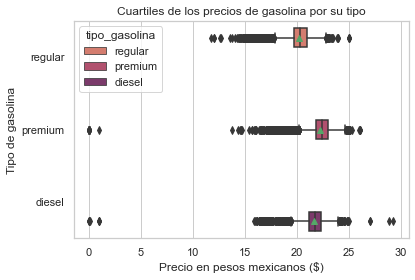

In [180]:
sns.set_theme(style="whitegrid")

box_gasolina = sns.boxplot(data=new_data, x="precio", y="tipo_gasolina", hue="tipo_gasolina",\
                            orient="h", palette="flare", showmeans=True)
box_gasolina.set_title("Cuartiles de los precios de gasolina por su tipo")
box_gasolina.set_xlabel("Precio en pesos mexicanos ($)")
box_gasolina.set_ylabel("Tipo de gasolina")
plt.show()

#### Interpretación:

Debe decirse que este diagrama de caja es un poco difícil de interpretar, ya que la visualización de la información es "pequeña" debido a los datos que se encuentran más en los extremos: los "*fliers*". Lo importante a mencionar de esta gráfica es que podemos observar que los precios mínimos de la venta de gasolina `premium` y `diesel` son de 0 y 0.1 pesos (este último dato lo obtuvimos en algún inciso cuando nos preguntamos por aquellas estaciones que vendieran gasolina más barata que no fuera gratis). Asímismo observamos que el precio más alto fue del tipo de gasolina `diesel` con 29.29 pesos. A su vez, observamos que realmente se empeiza a acumular la mayor parte de probabilidad en la distribución de los precios de la gasolina por su tipo por arriba de los 15 pesos.

Debido a ello, ofreceremos otra gráfica que representa más claramente la distribución de los precios de la gasolina: una gráfica en la cual quitamos los "*fliers*".

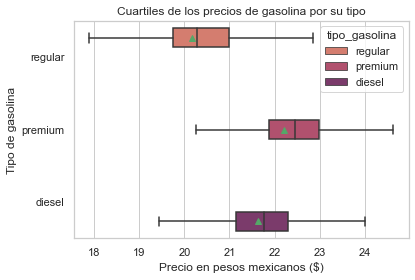

In [181]:
box_gasolina = sns.boxplot(data=new_data, x="precio", y="tipo_gasolina", hue="tipo_gasolina",\
                            orient="h", palette="flare", showmeans=True, showfliers=False)
box_gasolina.set_title("Cuartiles de los precios de gasolina por su tipo")
box_gasolina.set_xlabel("Precio en pesos mexicanos ($)")
box_gasolina.set_ylabel("Tipo de gasolina")
plt.show()

#### Interpretación:

* En esta gráfica está representada gran parte de la informació obtenida en el primer `describe()` como el promedio y los cuartiles de los tres tipos de gasolina. Aquí también confirmamos la información de comparación como el hecho de que el promedio de venta más barato de gasolina de un tipo corresponde al de la `regular`, mientras que el más caro en promedio fue el de la `premium`. 


* Lo que sí podemos observar es que la distribución de la gasolina del tipo `premium` se mueve más en rangos de precios caros en comparación de las otras dos distribuciones, a pesar de que la gasolina `diesel` tiene el precio más caro existente.


* Otra cosa que podemos notar es que los extremos de las distribuciones "se parecen" en el sentido de que los tres rangos parecen tener la misma "distancia" a pesar de encontrarse en diferentes "posiciones" de precios. 


* También es notable mencionar que en los tres casos el promedio del precio de la gasolina es menor al precio de la media. Esto puede decirnos que la mitad de las estaciones venden un precio de gasolina (por tipo) menor o igual a unos pesos arriba del promedio.

---
7. Del *data frame* `new_data` generamos 3 `histogramas` de las distribuciones de los precios de los distintos tipos de gasolina.

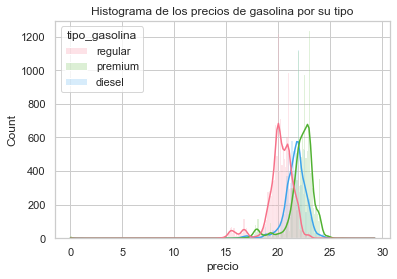

In [182]:
hist_gasolina = sns.histplot(data=new_data, x="precio", hue="tipo_gasolina",\
                             palette="husl", kde=True, alpha=0.2)
hist_gasolina.set_title("Histograma de los precios de gasolina por su tipo")
plt.show()

Del mismo modo que se hizo para la gráfica del diagrama de caja, podemos intentar recrear un histograma que intente simular la omisión de los "*fliers*" como en el `boxplot`. De esta manera, se decidió tomar aquellos precios que fueran mayores a 10 pesos. Así obtenemos una gráfica un poco más clara, aunque nos vimos en la necesidad de "borrar" o no considerar algunos datos, y esto no está bien.

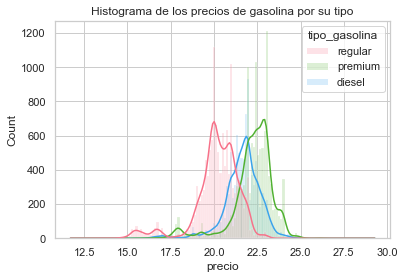

In [183]:
sin_fliers = new_data[new_data['precio'] > 10]

hist_gasolina = sns.histplot(data=sin_fliers, x="precio", hue="tipo_gasolina",\
                             palette="husl", kde=True, alpha=0.2)
hist_gasolina.set_title("Histograma de los precios de gasolina por su tipo")
plt.show()

---
**~ Plotly**

In [184]:
import plotly.express as px

8. Generamos un mapa que muestra las estaciones de las que tenemos registro en la base de datos.

In [185]:
mapa_estaciones = px.scatter_geo(data_frame=data, lat="lat", lon="lon",\
                                 title="Geolocalización de las estaciones de gasolina",\
                                 projection="natural earth")
mapa_estaciones.show()

**Pregunta obligada**: ¿Existen estaciones que no están en México? 

Sí, al parecer se tienen registros de estaciones que se encuentran en el Océano Pacífico, otras se encuentran cerca de Groenlandia y una que se encuentra cerca de Estados Unidos en el Golfo de México.  

Si estas estaciones no son para barcos, pequeños yates o lanchas, entonces podemos considerar que se trata de un error de dedo, o tal vez de un error fatal en el momento de registrar las coordenadas de las estaciones. Las estaciones que se encuentran cerca de México como aquellas que están en el Océano Pacífico y en el Golfo de México puede ser que estén erróneas en su localización por un erro de dedo en el que pusieron un dígito que no era, pues parece que están cerca de nuestro territorio. Pero las estaciones que se encuentran más en el norte quién sabe. Si vemos las coordenadas de una de ellas: (longitud = -19.48, latitud = 99.03), podemos suponer que se equivocaron en el orden de las mismas, pues tendría más sentido que las coordenadas fueran (longitud = -99.03, latitud = 19.48), ya que la mayoría de las estaciones en México se encuentran alrededor de ese rango, además de así se cumplirían las condiciones puestas en la pregunta `3.`

Habiendo dicho esto último, podemos estar seguro que esas estaciones que se encuentran cerca de Groenlandia son las 4 estaciones que obtuvimos en la búsqueda de los errores en el inciso de la función `lat()` y también en la de la función `long()`. 

Debido a que la gráfica es dinámica y mi computadora es muy lenta, no puedo acercarme mucho a los puntos, por lo que tampoco puedo hacer un conteo "a mano" (y más preciso) de cuáles son las estaciones que se encuentran fuera de México `:(`. tentativamente decimos que son 4 las de Groenlandia, 1 la del Pacífico y 1 la del Golfo. En total tenemos 6 estaciones fuera de nuestro territorio.

---
9. Generamos un mapa que muestra las estaciones que venden gasolina `regular`.

In [186]:
regular = data[data['regular'].notna()]

mapa_reg = px.scatter_geo(data_frame=regular, lat="lat", lon="lon",\
                          title="Geolocalización de las estaciones que venden gasolina regular",\
                         projection="natural earth")
mapa_reg.show()

**Pregunta obligada**: ¿Existen estaciones que no están en México?

Sí, parece ser que siguen estando las mismas 6 estaciones que encontramos en la pregunta pasada. En este momento se puede afirmar que estas tentativas 6 estaciones venden gasolina `regular`. La explicación/suposición de por qué estas estaciones se encuentran prácticamente en el mar es la misma.

---
10. Generamos un mapa que muestra las estaciones que venden gasolina `premium`. 

In [187]:
premium = data[data['premium'].notna()]

mapa_prem = px.scatter_geo(data_frame=premium, lat="lat", lon="lon",\
                           title="Geolocalización de las estaciones que venden gasolina premium",\
                          projection="natural earth")
mapa_prem.show()

**Pregunta obligada**: ¿Existen estaciones que no están en México?

A pesar de ser repetitivos, recalcamos que parece ser que siguen siendo mismas estaciones que encontramos en la pregunta `8.`, así que podemos decir que estas gasolineras también venden gasolina `premium`. La explicación/suposición de por qué estas estaciones se encuentran fuera de México es la misma.

---
11. Generamos un mapa que muestra las estaciones que venden gasolina `diesel`.

In [188]:
diesel = data[data['diesel'].notna()]

mapa_die = px.scatter_geo(data_frame=diesel, lat="lat", lon="lon",\
                          title="Geolocalización de las estaciones que venden gasolina diesel",\
                         projection="natural earth")
mapa_die.show()

**Pregunta obligada**: ¿Existen estaciones que no están en México?

Por último, repetimos la cuestión de que al parecer las mismas estaciones que encontramos en la pregunta `8.` están fuera de México y también venden gasolina `diesel`. De hecho en este momento podríamos afirmar que venden los tres tipos de gasolina. De todas maneras, debido a que no podemos acercarnos tanto al mapa, no podemos estar seguros de que realmente no estén dos estaciones muy cerca y que una de ellas no venda gasolina `diesel`. La explicación/suposición de por qué estas estaciones se encuentran fuera del territorio mexicano es la misma.

---